###  Practicum #2 - Maggie Sleziak
####  Regis University

<B> 
<BR>
<BR>Data set from: 
 https://www.ncdc.noaa.gov/data-access/marineocean-data/noaa-global-surface-temperature-noaaglobaltemp
<BR>NOAA Merged Land Ocean Global Surface Temperature Analysis (NOAAGlobalTemp)
<BR>
<BR>Data: NCEI spatial average time series of monthly data
<BR>Read the file:
<BR>From: https://www.ncdc.noaa.gov/data-access/marineocean-data/noaa-global-surface-temperature-noaaglobaltemp
<BR>
<BR>Ascii Time Series: ftp://ftp.ncdc.noaa.gov/pub/data/noaaglobaltemp/operational/
<BR>Monthly and annual land–ocean temperature time series 
<BR>are available from 1880 to present for several zonal bands
<BR>file name convention for areal average (aravg) time series:
<BR>ann=annual average
<BR>mon=monthly average
<BR>land_ocean=merged land-ocean surface temperature
<BR>land=land surface temperature for air
<BR>ocean=ocean surface temperature for water
<BR>latitudes=southern and northern limits of areal average
<BR>v=version number
<BR>yyyymm=date for the latest data
<BR>
<BR>Monthly data (aravg.mon.*) :
<BR>1st column = year
<BR>2nd column = month
<BR>3rd column = anomaly of temperature (K)
<BR>4th column = total error variance (K**2)
<BR>5th column = high-frequency error variance (K**2)
<BR>6th column = low-frequency error variance (K**2)
<BR>7th column = bias error variance (K**2)
<BR>8th column = diagnostic variable
<BR>9th column = diagnostic variable
<BR>10th column= diagnostic variable
<BR>



<br>
<br>Exploration of a univariate problem with lagged data

<BR><BR>
Reference: 
<BR>
<BR>Brownlee, Jason. Machine Learning Mastery with Python: Deep Learning for Time Series Forecasting. Jason Brownlee, 2018. 
<BR>

In [1]:

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
from matplotlib import pyplot
import numpy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



Using TensorFlow backend.


<BR><BR><B>Load and check dataset</B>

In [2]:
# Start time to time this process: 
startTime = datetime.now()

def parser(x):
	return datetime.strptime(x, '%Y-%m')
series = read_csv('/Users/maggie/Documents/dataScience/practicum2/data/monthlyClean2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# check
print(series.head())

YearMonth
1880-01-01   -0.239575
1880-02-01   -0.376476
1880-03-01   -0.395847
1880-04-01   -0.296963
1880-05-01   -0.309813
Name: TempAnomaly, dtype: float64


<function print>

Shape:
(1665,)


<function print>

head:


YearMonth
1880-01-01   -0.239575
1880-02-01   -0.376476
1880-03-01   -0.395847
1880-04-01   -0.296963
1880-05-01   -0.309813
1880-06-01   -0.405013
1880-07-01   -0.366857
1880-08-01   -0.283096
1880-09-01   -0.287228
1880-10-01   -0.375328
Name: TempAnomaly, dtype: float64

<function print>

tail:


YearMonth
2017-12-01    0.539903
2018-01-01    0.458760
2018-02-01    0.423702
2018-03-01    0.576104
2018-04-01    0.563611
2018-05-01    0.547566
2018-06-01    0.489483
2018-07-01    0.535664
2018-08-01    0.515230
2018-09-01    0.562892
Name: TempAnomaly, dtype: float64

<function print>

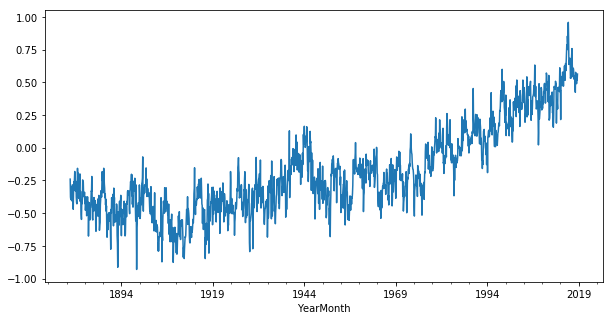

In [3]:

# A plot of the series shows increasing trend.
print
print('Shape:')
print(series.shape)
print
print('head:')
series.head(10)
print
print('tail:')
series.tail(10)
print

%matplotlib inline
pyplot.rcParams['figure.figsize'] = [10, 5]
series.plot()
pyplot.show()


<BR><BR><BR><B>Data Preparation: Transforms</B>

raw_values:
(1665,)
[-0.239575 -0.376476 -0.395847 -0.296963 -0.309813 -0.405013 -0.366857
 -0.283096 -0.287228 -0.375328]


<function print>

Stationary:
(1664,)
0   -0.136901
1   -0.019371
2    0.098884
3   -0.012850
4   -0.095200
5    0.038156
6    0.083761
7   -0.004132
8   -0.088100
9   -0.094352
dtype: float64


<function print>

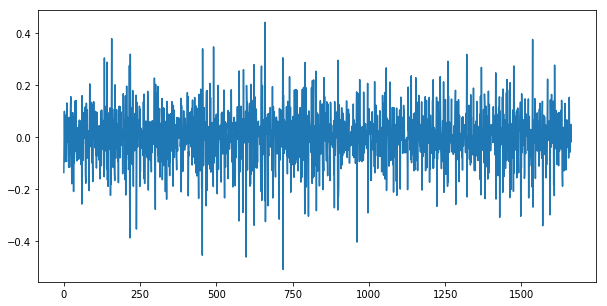

In [4]:
# Data Preparation
# Before fitting the MLP (Multi Layer Perceptron Network) Model, we need to transform the data
# A) Tranform the time series data so it is stationary 
# (mean, variance, autocorrelation, etc. are all constant over time.)
# Here we are adding a lag=1 differencing to remove the increasing trend in the data.
# The new value is the difference between the current and previous values

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


raw_values = series.values
diff_values = difference(raw_values, 1)


print('raw_values:')
print(raw_values.shape)
print(raw_values[:10,])
print

# Now we will have 138 values
print('Stationary:')
print(diff_values.shape)
print(diff_values[:10,])
print

diff_values.plot()
pyplot.show()

<BR><BR><BR><B>Transform to Supervised Problem</B>

In [5]:
# To Supervised

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

lag = 1
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag)
supervised_values = supervised.values[lag:,:]

print('Stationary:')
print(diff_values.shape)
print(diff_values[:10,])
print

print('Supervised_values:')
print(supervised.shape)
print(supervised_values)
print

Stationary:
(1664,)
0   -0.136901
1   -0.019371
2    0.098884
3   -0.012850
4   -0.095200
5    0.038156
6    0.083761
7   -0.004132
8   -0.088100
9   -0.094352
dtype: float64


<function print>

Supervised_values:
(1664, 2)
[[-0.136901 -0.019371]
 [-0.019371  0.098884]
 [ 0.098884 -0.01285 ]
 ...
 [-0.058083  0.046181]
 [ 0.046181 -0.020434]
 [-0.020434  0.047662]]


<function print>

<BR><BR><BR><B>Split data into train and test, input, output values</B>

In [6]:

# Split the data in two parts: training and test set
# The years are 1880-2018, so 139 years total. 
# We will use 2/3 (Around 1000 months) of the data for training and 1/3 for testing
# 
train, test = supervised_values[0:-661], supervised_values[-661:]

print('Train:')
print(train.shape)
print
print
print('Train:')
print(train)
print
print('Test:')
print(test.shape)
print
print
print('Test:')
print(test)
print


Train:
(1002, 2)


<function print>

<function print>

Train:
[[-0.136901 -0.019371]
 [-0.019371  0.098884]
 [ 0.098884 -0.01285 ]
 ...
 [ 0.024553  0.044458]
 [ 0.044458  0.108484]
 [ 0.108484  0.022746]]


<function print>

Test:
(661, 2)


<function print>

<function print>

Test:
[[ 0.022746  0.009894]
 [ 0.009894  0.059476]
 [ 0.059476 -0.028413]
 ...
 [-0.058083  0.046181]
 [ 0.046181 -0.020434]
 [-0.020434  0.047662]]


<function print>

In [7]:
# Data Preparation - Continuation
# C) Transform the observations to have a specific scale. Rescale all values to -1 to 1

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

scaler, train_scaled, test_scaled = scale(train, test)

print(scaler)

print('Train:')
print(train_scaled.shape)
print
print
print('Train:')
print(train_scaled)
print
print('Test:')
print(test_scaled.shape)
print
print
print('Test:')
print(test_scaled)
print

MinMaxScaler(copy=True, feature_range=(-1, 1))
Train:
(1002, 2)


<function print>

<function print>

Train:
[[-0.21546181  0.03154466]
 [ 0.03154466  0.28007482]
 [ 0.28007482  0.04524949]
 ...
 [ 0.12385736  0.16569063]
 [ 0.16569063  0.30025062]
 [ 0.30025062  0.12005969]]


<function print>

Test:
(661, 2)


<function print>

<function print>

Test:
[[ 0.12005969  0.09304933]
 [ 0.09304933  0.19725315]
 [ 0.19725315  0.01254157]
 ...
 [-0.04981427  0.16931176]
 [ 0.16931176  0.02931061]
 [ 0.02931061  0.1724243 ]]


<function print>

In [8]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]



In [9]:
# MLP fit

def fit_model(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	modelMLP = Sequential()
	modelMLP.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
	modelMLP.add(Dense(1))
	modelMLP.compile(loss='mean_squared_error', optimizer='adam')
	modelMLP.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return modelMLP

In [10]:
# Function to run trail job
def trialjob(repeats, epochs, neurons):
	error_scores = list()
	fit_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		modelMLP = fit_model(train_scaled, batch_size, epochs, neurons)
		# forecast test dataset (X)
		test_reshaped = test_scaled[:,0:-1]
		output = modelMLP.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			# print('yhat')
			# print(yhat)
			X = test_scaled[i, 0:-1]
			# print('for X')
			# print(X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# print('yhat invert scaling')
			# print(yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# print('**yhat invert difference')
			# print(yhat)
			# print
			# store forecast
			predictions.append(yhat)
		# report performance
		real_y = raw_values[-661:]
		trainorig_y = raw_values[:1000]
		mse = mean_squared_error(real_y, predictions)
		rmse = sqrt(mean_squared_error(real_y, predictions))
		r2score = r2_score(real_y, predictions)


		print('Test number: %d for: %d neurons, and %d epochs' % (r+1, neurons, epochs))
		print('%d) Test RMSE: %.5f' % (r+1, rmse))
		print('MSE: %.5f' % mse)
		print('Goodness of fit: %.5f' % r2score)
		print  
        
        # Because X (and thus predictions) is one day behind Y. The time series plot look a bit off. 
        # Let's place back the data so we can see the plots better
        # The prediction “prediction” is one index ahead of real output “test_y”.
		plot_y = real_y[:-1]
		plot_predictions = predictions[1:]
      
		pyplot.plot(trainorig_y,color='blue', label = 'Real Y - training set', lw = 0.5, alpha = 0.75)
		pyplot.plot([None for i in trainorig_y] + [x for x in plot_y], color='green', label = 'Real Y test set', lw = 0.5, alpha = 0.75)
		pyplot.plot([None for i in trainorig_y] + [x for x in plot_predictions], color='red', label = 'Prediction for test set',lw = 0.75, alpha = 1)
		pyplot.legend()
		pyplot.show()
        
		pyplot.plot(plot_y[-200:], color='green', label = 'Real Temp at T+1 Count')
		pyplot.plot(plot_predictions[-200:], color='red', label = 'Predicted Temp at T+1 Count')
		pyplot.legend()
		pyplot.show()
        
		model_mse.append(mse)
		model_rmse.append(rmse)
		model_r2.append(r2score)
		model_epoch.append(epochs)
		model_neuron.append(neurons)
		print()
		print('________________________________________________________________________________')
        


<BR><BR><BR><B>Train and fit the model, evaluate results</B>

Test number: 1 for: 2 neurons, and 50 epochs
1) Test RMSE: 0.09054
MSE: 0.00820
Goodness of fit: 0.90563


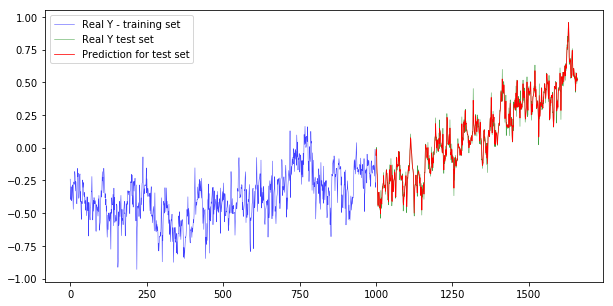

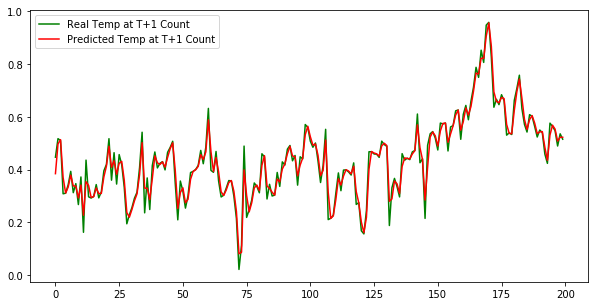


________________________________________________________________________________
Test number: 2 for: 2 neurons, and 50 epochs
2) Test RMSE: 0.09038
MSE: 0.00817
Goodness of fit: 0.90596


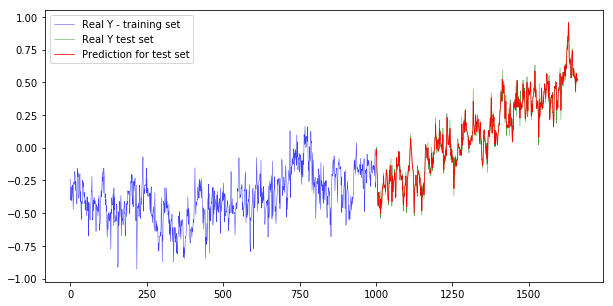

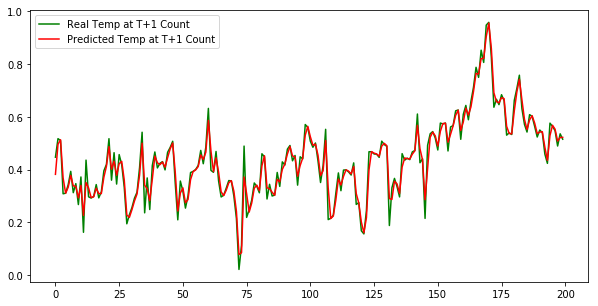


________________________________________________________________________________
Test number: 3 for: 2 neurons, and 50 epochs
3) Test RMSE: 0.09714
MSE: 0.00944
Goodness of fit: 0.89138


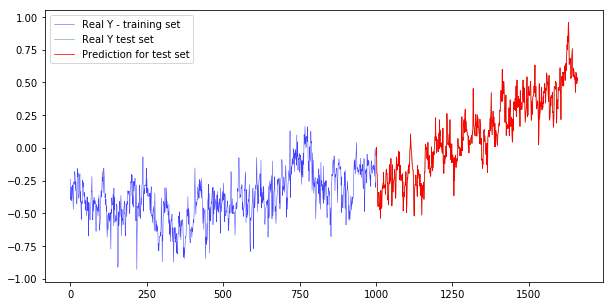

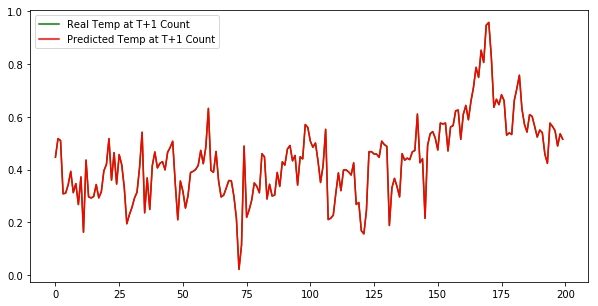


________________________________________________________________________________
Test number: 4 for: 2 neurons, and 50 epochs
4) Test RMSE: 0.09210
MSE: 0.00848
Goodness of fit: 0.90236


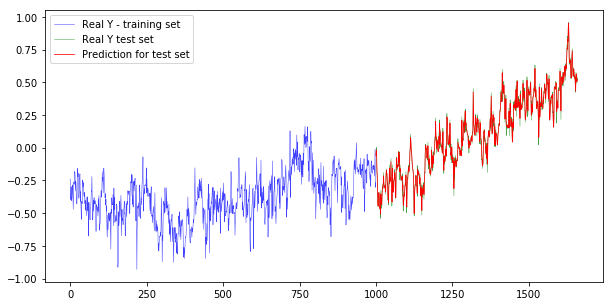

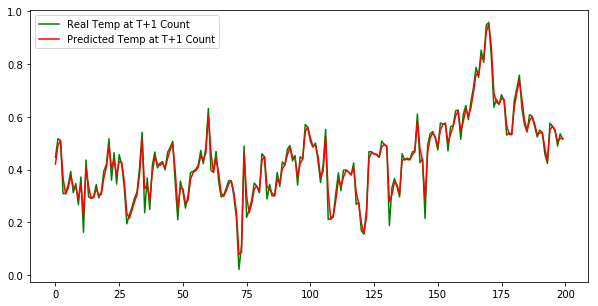


________________________________________________________________________________
Test number: 5 for: 2 neurons, and 50 epochs
5) Test RMSE: 0.09195
MSE: 0.00845
Goodness of fit: 0.90267


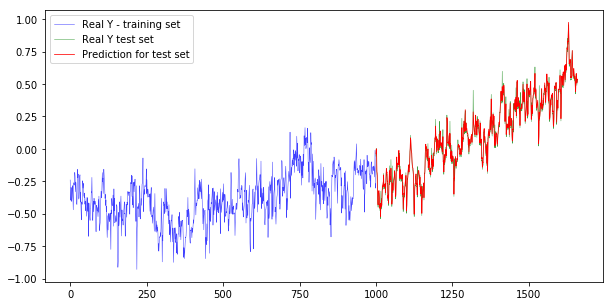

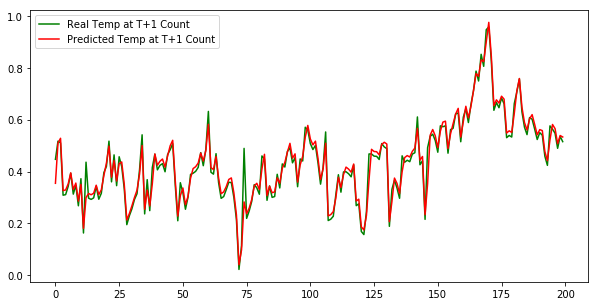


________________________________________________________________________________
Test number: 1 for: 2 neurons, and 100 epochs
1) Test RMSE: 0.09048
MSE: 0.00819
Goodness of fit: 0.90576


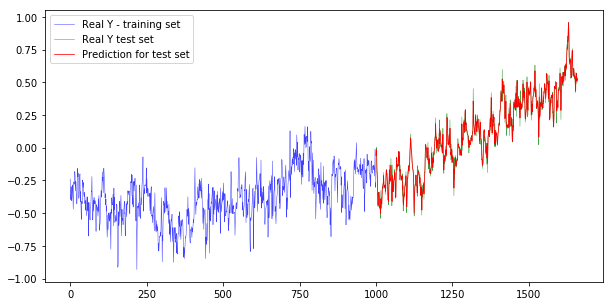

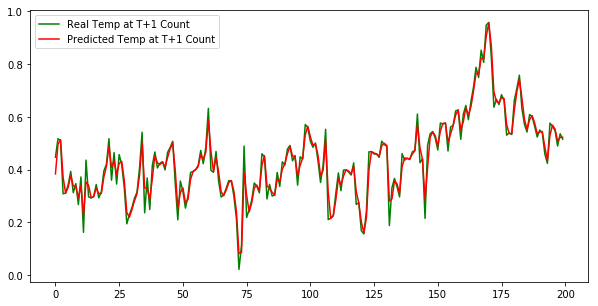


________________________________________________________________________________
Test number: 2 for: 2 neurons, and 100 epochs
2) Test RMSE: 0.09714
MSE: 0.00944
Goodness of fit: 0.89138


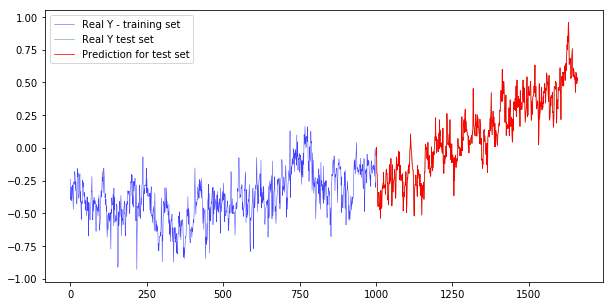

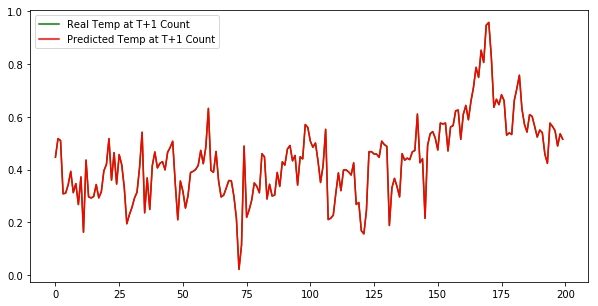


________________________________________________________________________________
Test number: 3 for: 2 neurons, and 100 epochs
3) Test RMSE: 0.09047
MSE: 0.00818
Goodness of fit: 0.90578


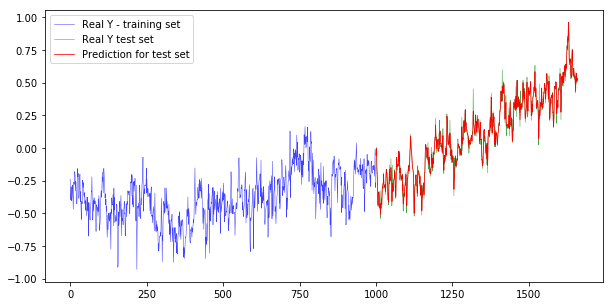

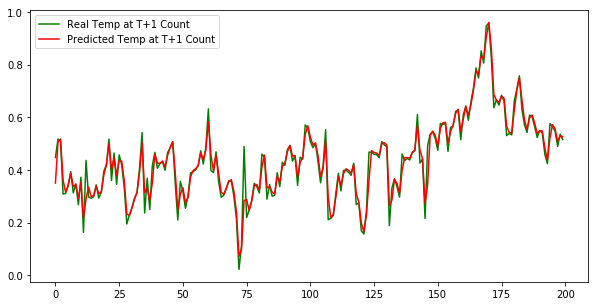


________________________________________________________________________________
Test number: 4 for: 2 neurons, and 100 epochs
4) Test RMSE: 0.09714
MSE: 0.00944
Goodness of fit: 0.89138


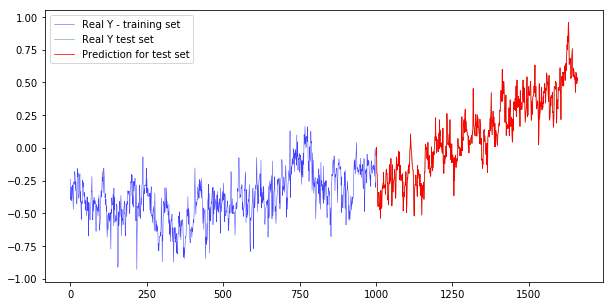

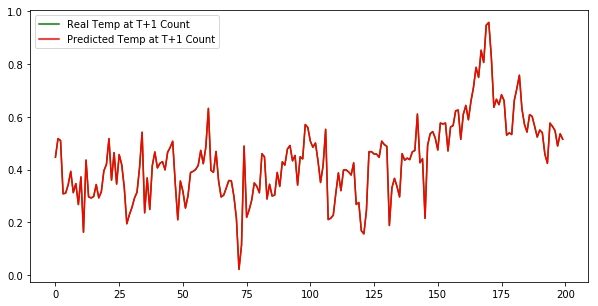


________________________________________________________________________________
Test number: 5 for: 2 neurons, and 100 epochs
5) Test RMSE: 0.09060
MSE: 0.00821
Goodness of fit: 0.90551


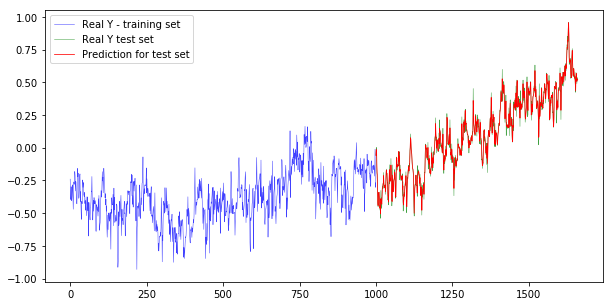

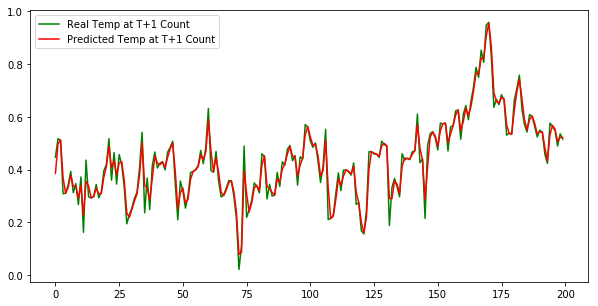


________________________________________________________________________________
Test number: 1 for: 2 neurons, and 200 epochs
1) Test RMSE: 0.09086
MSE: 0.00825
Goodness of fit: 0.90497


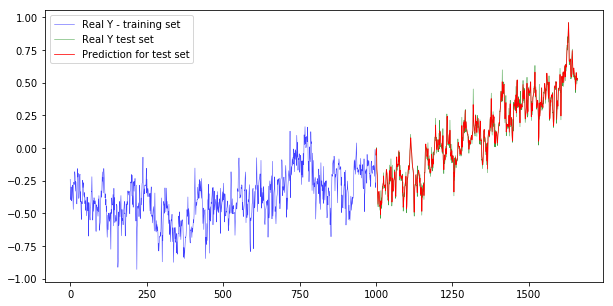

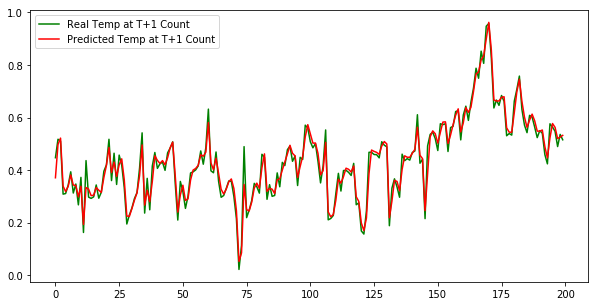


________________________________________________________________________________
Test number: 2 for: 2 neurons, and 200 epochs
2) Test RMSE: 0.09714
MSE: 0.00944
Goodness of fit: 0.89138


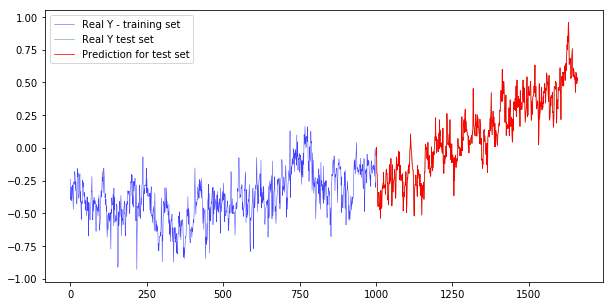

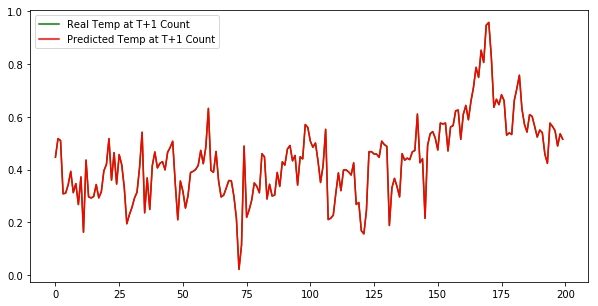


________________________________________________________________________________
Test number: 3 for: 2 neurons, and 200 epochs
3) Test RMSE: 0.09714
MSE: 0.00944
Goodness of fit: 0.89138


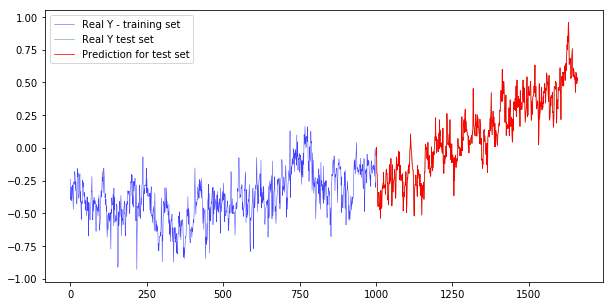

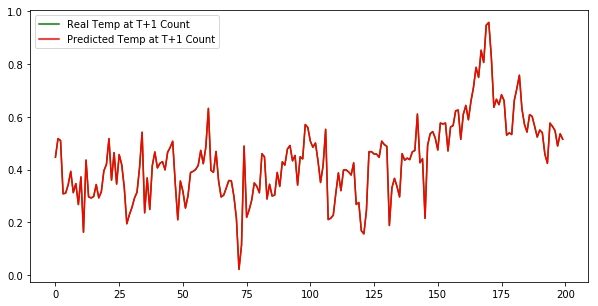


________________________________________________________________________________
Test number: 4 for: 2 neurons, and 200 epochs
4) Test RMSE: 0.09047
MSE: 0.00819
Goodness of fit: 0.90577


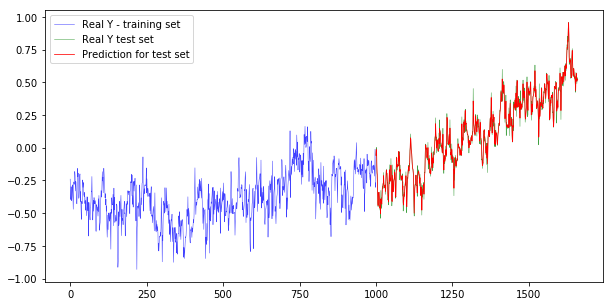

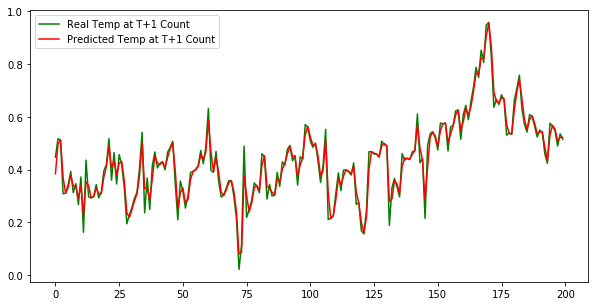


________________________________________________________________________________
Test number: 5 for: 2 neurons, and 200 epochs
5) Test RMSE: 0.09058
MSE: 0.00820
Goodness of fit: 0.90556


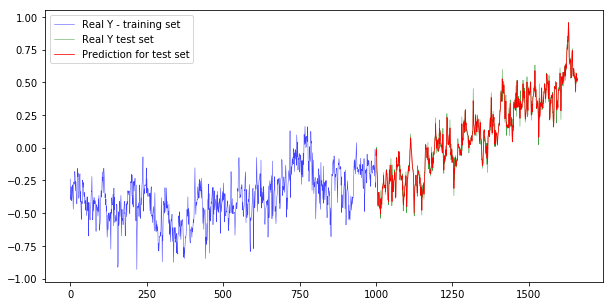

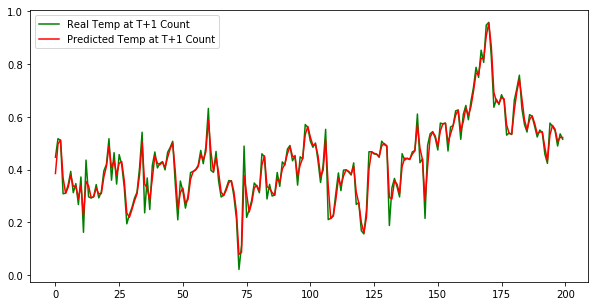


________________________________________________________________________________
Test number: 1 for: 2 neurons, and 300 epochs
1) Test RMSE: 0.09056
MSE: 0.00820
Goodness of fit: 0.90560


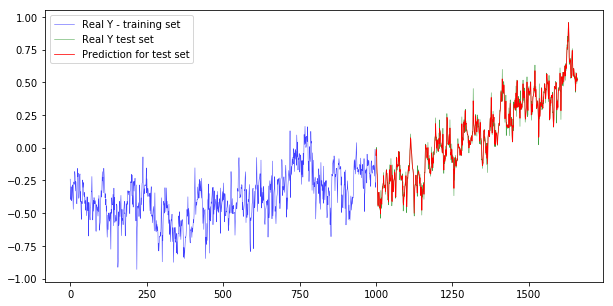

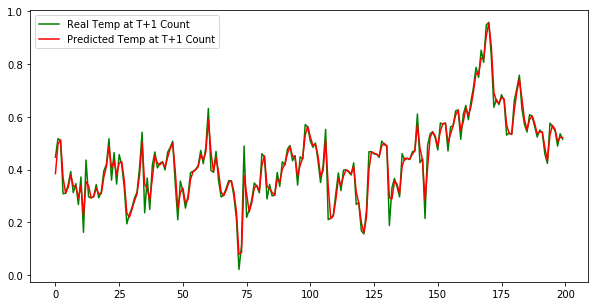


________________________________________________________________________________
Test number: 2 for: 2 neurons, and 300 epochs
2) Test RMSE: 0.09714
MSE: 0.00944
Goodness of fit: 0.89138


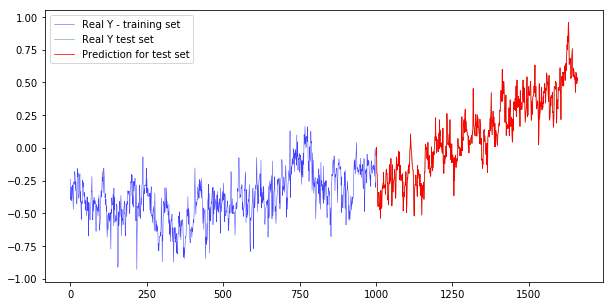

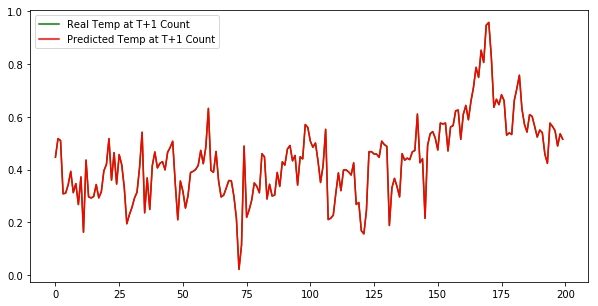


________________________________________________________________________________
Test number: 3 for: 2 neurons, and 300 epochs
3) Test RMSE: 0.09041
MSE: 0.00817
Goodness of fit: 0.90590


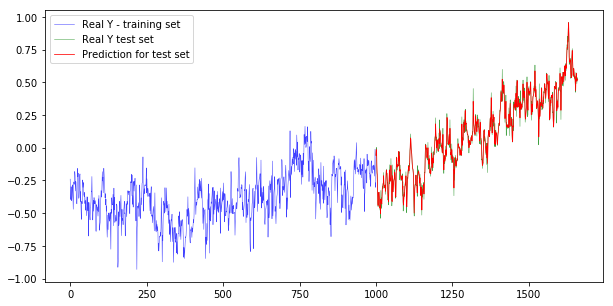

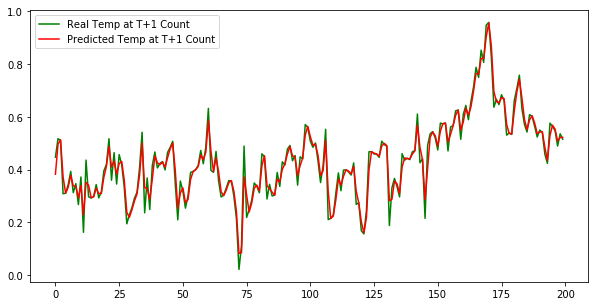


________________________________________________________________________________
Test number: 4 for: 2 neurons, and 300 epochs
4) Test RMSE: 0.09040
MSE: 0.00817
Goodness of fit: 0.90593


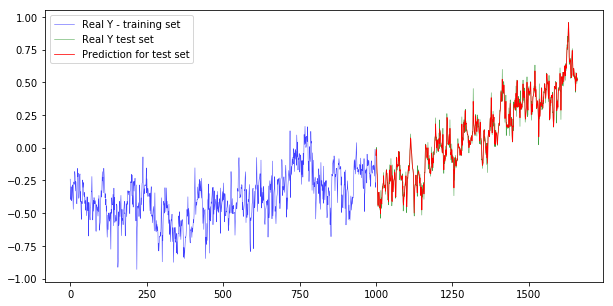

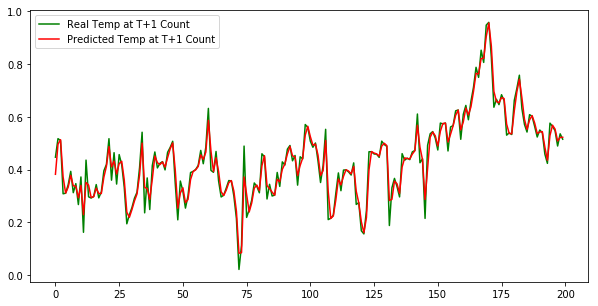


________________________________________________________________________________
Test number: 5 for: 2 neurons, and 300 epochs
5) Test RMSE: 0.09042
MSE: 0.00818
Goodness of fit: 0.90589


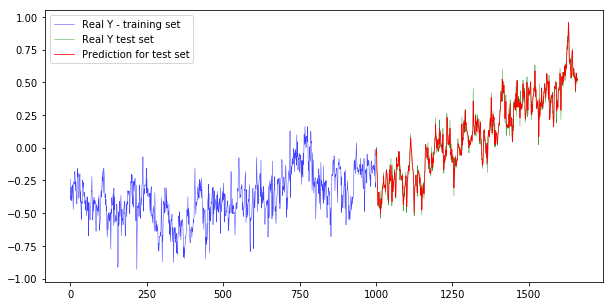

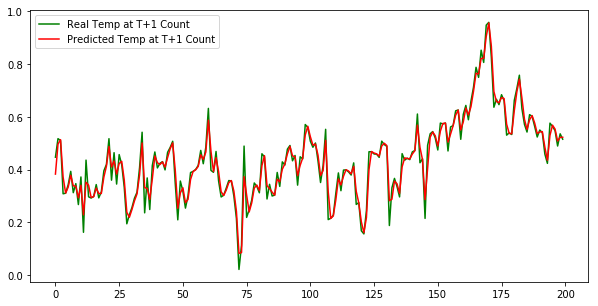


________________________________________________________________________________
Test number: 1 for: 2 neurons, and 400 epochs
1) Test RMSE: 0.09041
MSE: 0.00817
Goodness of fit: 0.90590


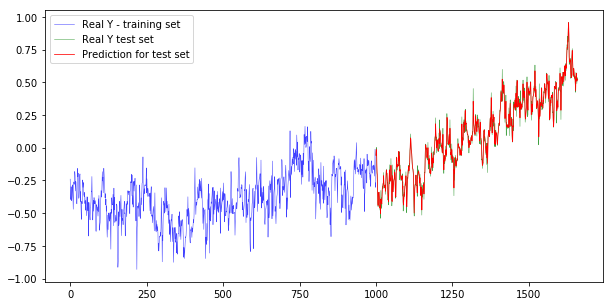

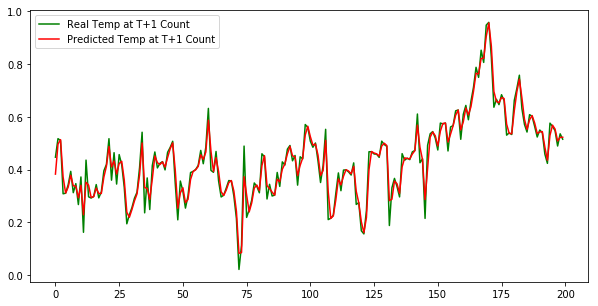


________________________________________________________________________________
Test number: 2 for: 2 neurons, and 400 epochs
2) Test RMSE: 0.09048
MSE: 0.00819
Goodness of fit: 0.90576


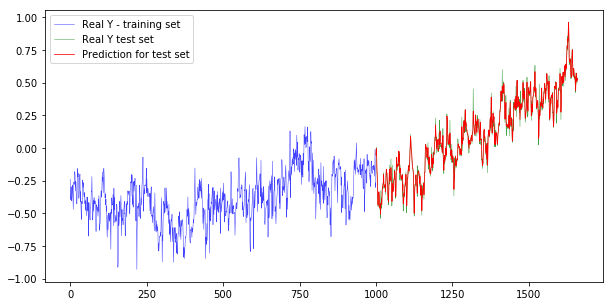

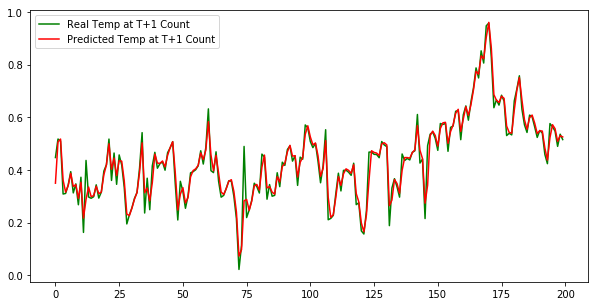


________________________________________________________________________________
Test number: 3 for: 2 neurons, and 400 epochs
3) Test RMSE: 0.09049
MSE: 0.00819
Goodness of fit: 0.90574


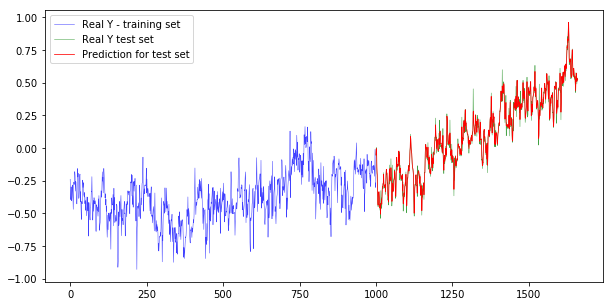

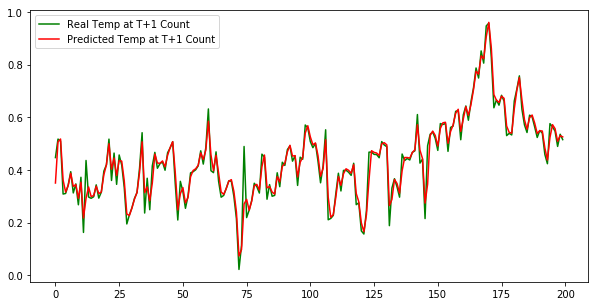


________________________________________________________________________________
Test number: 4 for: 2 neurons, and 400 epochs
4) Test RMSE: 0.09205
MSE: 0.00847
Goodness of fit: 0.90246


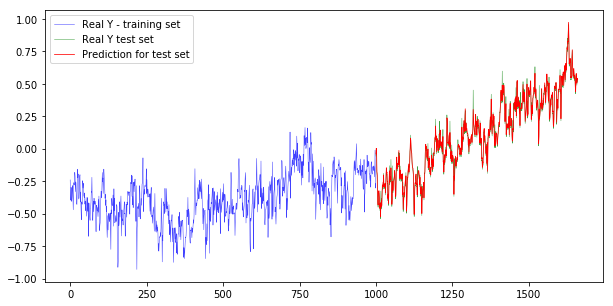

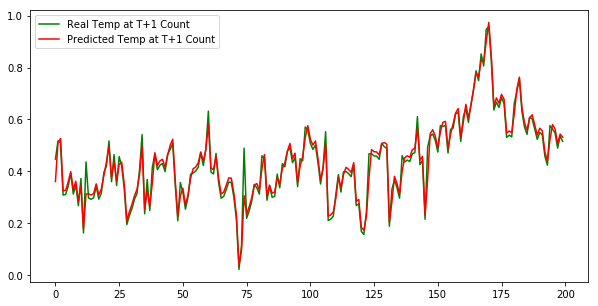


________________________________________________________________________________
Test number: 5 for: 2 neurons, and 400 epochs
5) Test RMSE: 0.09262
MSE: 0.00858
Goodness of fit: 0.90125


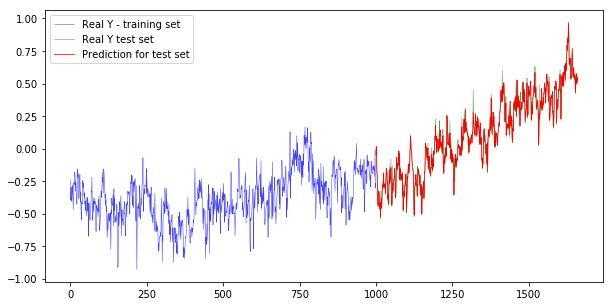

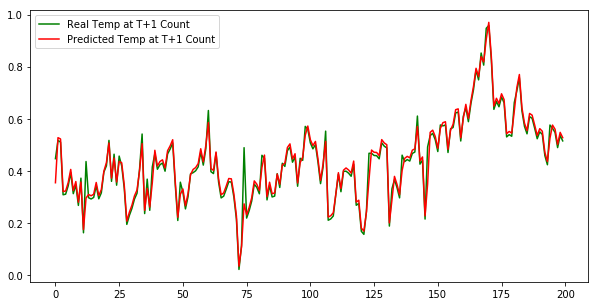


________________________________________________________________________________


In [11]:
# MLP

# Adam is optimization different to classical stochastic gradient descent.

# Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and 
# the learning rate does not change during training.

# Adam combines two other extensions of stochastic gradient descent. 
#  Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter 
##   learning rate that improves performance on problems with sparse gradients
# Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning 
##  rates that are adapted based on the average of recent magnitudes of the gradients for the weight (how quickly it changes)

# MSE - Risk function, measure of the quality of the estimator. 
# Epochs - number of forward and backward passes of all training examples
# Batch - number of training examples in a forward/backwards pass
# Interations or repeats = number of passes 

model_epoch = []
model_neuron = []
model_rmse = []
model_r2 = []
model_mse = []

repeats = 5
neurons = 2
# vary training epochs
epochs = [50, 100, 200, 300, 400]
# epochs = [10]
for e in epochs:
	trialjob(repeats, e, neurons)


In [12]:
predictionSummary = pd.DataFrame({
                                  'Epochs':np.array(model_epoch),
                                  'Neurons':np.array(model_neuron),
                                  'R2':np.array(model_r2),
                                  'RMSE':np.array(model_rmse),
                                  'MSE':np.array(model_mse),})
                                  

print('MLP Lag1 Results - Sorted by R2 (Coefficient Of Determination - Goodness of fit) :')
print()
print(predictionSummary.sort_values(by=['R2'], ascending=False)) 
print()
print(predictionSummary.describe())

MLP Lag1 Results - Sorted by R2 (Coefficient Of Determination - Goodness of fit) :

    Epochs  Neurons        R2      RMSE       MSE
1       50        2  0.905961  0.090384  0.008169
18     300        2  0.905926  0.090401  0.008172
17     300        2  0.905902  0.090412  0.008174
20     400        2  0.905899  0.090414  0.008175
19     300        2  0.905890  0.090418  0.008175
7      100        2  0.905785  0.090468  0.008185
13     200        2  0.905774  0.090474  0.008185
21     400        2  0.905765  0.090478  0.008186
5      100        2  0.905758  0.090481  0.008187
22     400        2  0.905737  0.090491  0.008189
0       50        2  0.905632  0.090542  0.008198
15     300        2  0.905599  0.090558  0.008201
14     200        2  0.905560  0.090576  0.008204
9      100        2  0.905514  0.090599  0.008208
10     200        2  0.904974  0.090857  0.008255
4       50        2  0.902672  0.091951  0.008455
23     400        2  0.902456  0.092053  0.008474
3       50      

In [13]:
predictionSummary.to_csv('./data/MLPSummary.csv')
# Get the time: 
print(datetime.now() - startTime)

0:20:17.706113
